In [1]:
import pandas as pd
import numpy as np
import time
from datetime import date

In [2]:
annees = [2018,2019,2020,2021]
frames = []
for an in annees:
    frames.append(
        pd.read_csv(f"./valeursfoncieres-{an}.txt", sep= '|', decimal=',', nrows= 1000000, low_memory=False))
data = pd.concat(frames)
df= data.copy()
df.shape

(4000000, 43)

In [3]:
#Ici on concaténe les lignes en fonction de l'adresse et de la date (groupby). 
# Puis (filter) permet de garder uniquement les groupes de lignes qui ont une longueur=1, ce qui signifie qu'il n'y a pas de doublons
#Donc les groupes de lignes avec plusieurs ventes à la même adresse et la même date sont supprimés du dataframe. 
df['key'] = df['Date mutation'].astype('str') + df['Type de voie'].astype('str') + df['Voie'].astype('str') + df['Code postal'].astype('str')
df = df.groupby('key').filter(lambda x : len(x) == 1)
df.shape

(957585, 44)

In [4]:
df = df[df['Valeur fonciere'] > 1]
df.shape

(945755, 44)

In [5]:
df = df[df['Type local'].notna()]
df.shape

(560031, 44)

In [6]:
missing_value_rate= df.isna().mean() * 100
missing_value_rate 

Identifiant de document       100.000000
Reference document            100.000000
1 Articles CGI                100.000000
2 Articles CGI                100.000000
3 Articles CGI                100.000000
4 Articles CGI                100.000000
5 Articles CGI                100.000000
No disposition                  0.000000
Date mutation                   0.000000
Nature mutation                 0.000000
Valeur fonciere                 0.000000
No voie                         0.923699
B/T/Q                          93.379295
Type de voie                    9.357161
Code voie                       0.000000
Voie                            0.001964
Code postal                     0.012678
Commune                         0.000000
Code departement                0.000000
Code commune                    0.000000
Prefixe de section             90.699265
Section                         0.004821
No plan                         0.000000
No Volume                     100.000000
1er lot         

In [7]:
df = df[df.columns[missing_value_rate < 65]]
df.shape

(560031, 23)

In [8]:
#On enlève toutes les variables inutiles + celles qui ont +de 70% de NA
df.drop(['No disposition','Section','No plan','Nature culture','1er lot','key'], axis=1, inplace=True)
df.shape

(560031, 17)

In [9]:
df['Date mutation'] = pd.to_datetime(df['Date mutation'], format="%d/%m/%Y")
df['annee'] = df['Date mutation'].dt.year
df['mois'] = df['Date mutation'].dt.month

In [143]:
#Transformer les mois en une fonction cyclique: 
# les variables "month_cos" , "month_sin", représentent le mois de l'année sous forme de coordonnées dans un cercle unitaire.
#Cela permet de capturer la périodicité des mois tout en évitant les erreurs de classification dues à la représentation linéaire de ces variables.
#data_2018_drop['mois_sin'] = np.sin(data_2018_drop['Mois'] * (2 * np.pi / 12))
#data_2018_drop['mois_cos'] = np.cos(data_2018_drop['Mois'] * (2 * np.pi / 12))

In [ ]:
#on va concaténer df et le csv sur code postal qu'ils ont en commun, et on aura le code région de chaque vente

In [ ]:
#ne pas utiliser longitude et latitude et le justifier
#prendre le code region 

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 560031 entries, 11 to 993771
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Date mutation              560031 non-null  datetime64[ns]
 1   Nature mutation            560031 non-null  object        
 2   Valeur fonciere            560031 non-null  float64       
 3   No voie                    554858 non-null  float64       
 4   Type de voie               507628 non-null  object        
 5   Code voie                  560031 non-null  object        
 6   Voie                       560020 non-null  object        
 7   Code postal                559960 non-null  float64       
 8   Commune                    560031 non-null  object        
 9   Code departement           560031 non-null  object        
 10  Code commune               560031 non-null  int64         
 11  Nombre de lots             560031 non-null  int64  

In [13]:
data_coderegion_codepostal= pd.read_csv("./data_coderegion_codepostal.csv", decimal='.',low_memory=False)

In [14]:
data_coderegion_codepostal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38934 entries, 0 to 38933
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   38934 non-null  int64  
 1   Code postal  38934 non-null  int64  
 2   code_region  38934 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 912.6 KB


In [15]:
data_coderegion_codepostal=data_coderegion_codepostal.drop(columns='Unnamed: 0')
data_coderegion_codepostal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38934 entries, 0 to 38933
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Code postal  38934 non-null  int64  
 1   code_region  38934 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 608.5 KB


In [16]:
#il faut supprimer les doublons et avoir: 1 code postal --> 1 code région
data_coderegion_codepostal = data_coderegion_codepostal.drop_duplicates(subset="Code postal", keep="first")
data_coderegion_codepostal.sort_values(by='Code postal')

,Code postal,code_region
54,1000,84.0
166,1090,84.0
9,1100,84.0
10,1110,84.0
49,1120,84.0
...,...,...
38932,97640,6.0
38912,97650,6.0
38913,97660,6.0
38915,97670,6.0


In [17]:
#Faire une jointure avec merge
df_new = pd.merge(data_coderegion_codepostal, df, on="Code postal", how="left", sort=False)

In [18]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 564237 entries, 0 to 564236
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Code postal                564237 non-null  int64         
 1   code_region                564237 non-null  float64       
 2   Date mutation              559960 non-null  datetime64[ns]
 3   Nature mutation            559960 non-null  object        
 4   Valeur fonciere            559960 non-null  float64       
 5   No voie                    554790 non-null  float64       
 6   Type de voie               507562 non-null  object        
 7   Code voie                  559960 non-null  object        
 8   Voie                       559949 non-null  object        
 9   Commune                    559960 non-null  object        
 10  Code departement           559960 non-null  object        
 11  Code commune               559960 non-null  float64 

In [20]:
df_new.head()

,Code postal,code_region,Date mutation,Nature mutation,Valeur fonciere,No voie,Type de voie,Code voie,Voie,Commune,Code departement,Code commune,Nombre de lots,Code type local,Type local,Surface reelle bati,Nombre pieces principales,Surface terrain,annee,mois
0,1400,84.0,2018-01-12,Vente,270700.0,75.0,RUE,0480,VICTOR HUGO,CHATILLON-SUR-CHALARONNE,01,93.0,0.0,1.0,Maison,75.0,4.0,354.0,2018.0,1.0
1,1400,84.0,2018-01-09,Vente,70000.0,18.0,RUE,0100,COMMERSON,CHATILLON-SUR-CHALARONNE,01,93.0,0.0,4.0,Local industriel. commercial ou assimilé,112.0,0.0,112.0,2018.0,1.0
2,1400,84.0,2018-01-24,Vente,202500.0,2.0,LOT,A090,LES FRENES,CONDEISSIAT,01,113.0,0.0,1.0,Maison,108.0,5.0,1166.0,2018.0,1.0
3,1400,84.0,2018-01-26,Vente,20000.0,5.0,IMP,0160,GUICHENON,CHATILLON-SUR-CHALARONNE,01,93.0,0.0,1.0,Maison,43.0,3.0,24.0,2018.0,1.0
4,1400,84.0,2018-02-02,Vente,186520.0,6.0,RUE,0490,VOLTAIRE,CHATILLON-SUR-CHALARONNE,01,93.0,0.0,1.0,Maison,81.0,3.0,782.0,2018.0,2.0


In [21]:
df_new.to_csv("df_new.csv", index = True)

In [22]:
#corrélation entre code type local et les variables quantitatives
variables_numeriques = ["Code type local", "Nombre pieces principales", "Nombre de lots", "Valeur fonciere", "Surface reelle bati","Surface terrain"]

In [23]:
new_df=df_new[variables_numeriques]

In [24]:
matrice_correlation=new_df.corr()
print(matrice_correlation)

                           Code type local  Nombre pieces principales  \
Code type local                   1.000000                  -0.751338   
Nombre pieces principales        -0.751338                   1.000000   
Nombre de lots                    0.453395                  -0.315639   
Valeur fonciere                  -0.003852                   0.035275   
Surface reelle bati               0.072231                   0.013559   
Surface terrain                   0.194876                  -0.036300   

                           Nombre de lots  Valeur fonciere  \
Code type local                  0.453395        -0.003852   
Nombre pieces principales       -0.315639         0.035275   
Nombre de lots                   1.000000        -0.011052   
Valeur fonciere                 -0.011052         1.000000   
Surface reelle bati             -0.033578         0.118008   
Surface terrain                 -0.008191         0.079988   

                           Surface reelle bati  Surfa

In [ ]:
#Il n'y a que "Nombre de pièce principale" et "nombre de lot" qui semblent corréler

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

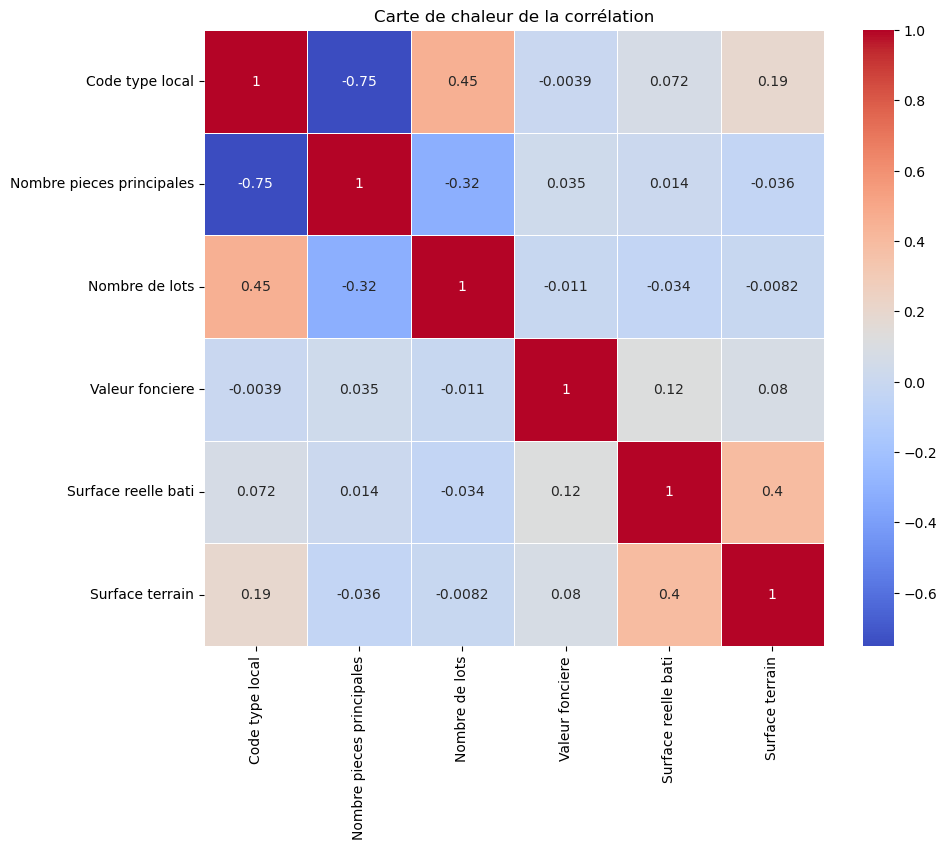

In [35]:
matrice_correlation=new_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(matrice_correlation, annot=True, cmap="coolwarm", linewidths=.5)
plt.title("Carte de chaleur de la corrélation")
plt.show()

In [ ]:
#Peut-être binariser la colonne code région et rajouter nbr de population par region
#et voir si elle sont coorélée avec code type local

In [ ]:
# Dupliquer df_new en df_classification: 
#ce dernier sera le data set initial pour faire la prédiction du type local

In [ ]:
#dans df_classification, supprimer les NA du type local (et du code type local)

In [36]:
df_classification= df_new.copy()

In [40]:
df_classification.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 564237 entries, 0 to 564236
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Code postal                564237 non-null  int64         
 1   code_region                564237 non-null  float64       
 2   Date mutation              559960 non-null  datetime64[ns]
 3   Nature mutation            559960 non-null  object        
 4   Valeur fonciere            559960 non-null  float64       
 5   No voie                    554790 non-null  float64       
 6   Type de voie               507562 non-null  object        
 7   Code voie                  559960 non-null  object        
 8   Voie                       559949 non-null  object        
 9   Commune                    559960 non-null  object        
 10  Code departement           559960 non-null  object        
 11  Code commune               559960 non-null  float64 

In [41]:
df_classification["Type local"].isna().mean()

0.007580148058351366

In [42]:
df_classification["Code type local"].isna().mean()

0.007580148058351366

In [43]:
#enlever les NA:
df_classification= df_classification.dropna(subset=["Type local"])
df_classification= df_classification.dropna(subset=["Code type local"])

In [ ]:
#Centrer et réduire les variables explicatives
#ici on prend que "nombre de pieces principales" et "nombre de lots" (pas la peine)

# Tester le modele de K-Means

In [ ]:
#Il faut centrer et réduire les données en amont (si besoin: si les variables ne sont pas de la même unité)

In [ ]:
#faire le split train/ test
#dans le train, faire fill.na median (moins sensible au variattion que la moyenne, ou knn imputer)
#faire fill. na (ou knn imputer) dans l'echantillon test aussi

In [46]:
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, f1_score, recall_score, precision_score, make_scorer, roc_curve, auc
from scipy import interp
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from statistics import mean

In [51]:
X = df_classification[['Nombre de lots','Nombre pieces principales']]

In [52]:
Y = df_classification[['Type local']]

In [69]:
from sklearn.model_selection import train_test_split
#70% des données pour l’apprentissage
#30% des données pour l'échantillon test
X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    test_size = 0.30,
                                                    stratify = Y,
                                                    random_state = 42)

In [70]:
y_test.value_counts(normalize=True)

Type local                              
Maison                                      0.569957
Appartement                                 0.277663
Dépendance                                  0.093292
Local industriel. commercial ou assimilé    0.059088
dtype: float64

In [71]:
y_train.value_counts(normalize=True)

Type local                              
Maison                                      0.569957
Appartement                                 0.277660
Dépendance                                  0.093295
Local industriel. commercial ou assimilé    0.059088
dtype: float64

In [72]:
X_train.isna().value_counts()

Nombre de lots  Nombre pieces principales
False           False                        391581
                True                            391
dtype: int64

In [73]:
X_train["Nombre pieces principales"].fillna(X_train["Nombre pieces principales"].median(), inplace=True)

In [74]:
X_train["Nombre pieces principales"].isna().value_counts()

False    391972
Name: Nombre pieces principales, dtype: int64

In [75]:
X_test["Nombre pieces principales"].fillna(X_test["Nombre pieces principales"].median(), inplace=True)

In [76]:
X_test["Nombre pieces principales"].isna().value_counts()

False    167988
Name: Nombre pieces principales, dtype: int64

In [ ]:
#Vérifier si moyenne et médiane des 2 variables explicatives sont sur la même échelle pour déterminer si on centre et on réduit

In [78]:
X.describe()

,Nombre de lots,Nombre pieces principales
count,559960.000000,559380.000000
mean,0.607527,3.035402
std,0.975440,1.899402
min,0.000000,0.000000
25%,0.000000,2.000000
50%,0.000000,3.000000
75%,1.000000,4.000000
max,141.000000,67.000000


In [ ]:
#Faire sans gridsearchCV pour commencer

In [80]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=10)
knn_model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=10)

In [82]:
from sklearn.metrics import confusion_matrix, classification_report

In [83]:
y_pred = knn_model.predict(X_test)
print(classification_report(y_test,y_pred))

                                          precision    recall  f1-score   support

                             Appartement       0.95      0.93      0.94     46644
                              Dépendance       0.67      0.99      0.80     15672
Local industriel. commercial ou assimilé       0.94      0.21      0.35      9926
                                  Maison       0.96      0.98      0.97     95746

                                accuracy                           0.92    167988
                               macro avg       0.88      0.78      0.76    167988
                            weighted avg       0.93      0.92      0.91    167988



ValueError: Shape of passed values is (4, 4), indices imply (2, 2)

In [84]:
pd.DataFrame(confusion_matrix(y_test,y_pred), columns=['pred_0','pred_1','pred_2','pred_3'], index=['obs_0','obs_1','obs_2','obs_3'])

,pred_0,pred_1,pred_2,pred_3
obs_0,43224,56,18,3346
obs_1,1,15555,116,0
obs_2,4,7642,2099,181
obs_3,2198,96,1,93451


In [ ]:
#Avec Gridsearch

In [85]:
from sklearn.metrics import make_scorer

In [86]:

parameters = {'n_neighbors' : np.arange(2,5,1)}
print(alerteCombinaison(parameters))

knn = KNeighborsClassifier()


f1_scorer = make_scorer(f1_score)
knn_model = GridSearchCV(knn, parameters, scoring = f1_scorer,
                   cv = ShuffleSplit(test_size=0.30, n_splits=1,
                                     random_state=0), verbose=1)
knn_model.fit(X_train, y_train )

NameError: name 'alerteCombinaison' is not defined

# Stats Descriptives

In [ ]:
#Décrire le nombre de vente en 2018: 1 ligne= 1 vente, donc 705820 ventes en 2018
#La moyenne de prix des ventes en 2018 est de 3.063606e+05
print(data_2018_new["Valeur fonciere"].describe())

In [92]:
data_2018_new["Type local"].value_counts()

Maison                                      328671
Appartement                                 208406
Dépendance                                   86042
Local industriel. commercial ou assimilé     34679
Name: Type local, dtype: int64

In [93]:
data_2018_new["Code type local"].value_counts()

1.0    328671
2.0    208406
3.0     86042
4.0     34679
Name: Code type local, dtype: int64

In [96]:
data_2018_new['Code type local']= data_2018_new['Code type local'].astype(object)

In [98]:
data_2018_new["Code type local"].value_counts()

1.0    328671
2.0    208406
3.0     86042
4.0     34679
Name: Code type local, dtype: int64

(0.0, 1000000000.0)

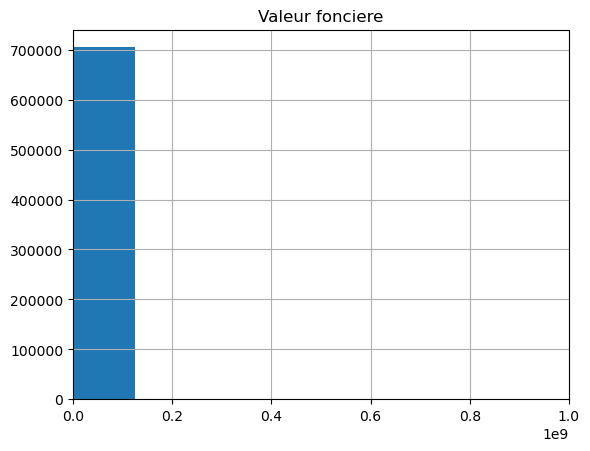

In [104]:
data_2018_new.hist(column='Valeur fonciere')
plt.xlim(0.0,1000000000)

array([[<Axes: title={'center': 'Appartement'}>,
        <Axes: title={'center': 'Dépendance'}>],
       [<Axes: title={'center': 'Local industriel. commercial ou assimilé'}>,
        <Axes: title={'center': 'Maison'}>]], dtype=object)

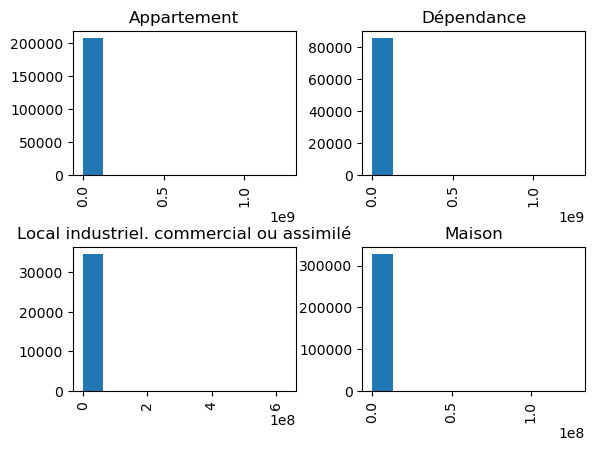

In [107]:
data_2018_new.hist(column="Valeur fonciere", by='Type local')

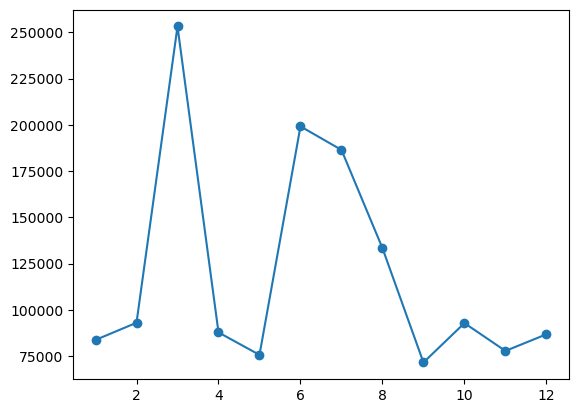

In [92]:
plt.plot(moyenne_valeur_fonciere_par_mois.index,moyenne_valeur_fonciere_par_mois.values, marker='o',linestyle='-')

In [ ]:
#graphe qui n'a pas vraiment de sens car les types de logements sont mélangés, donc les prix peuvent beaucoup varier. ICI n= 1000 il faudrait augmenter l'échantillon à 10000 voir tout le fichier.
#Faire le graphe nombre de vente au cours des mois 

In [93]:
ventes_par_mois= data.groupby('mois').size()

In [94]:
print(ventes_par_mois)

mois
1     416
2     216
3      10
4      24
5      69
6      16
7      15
8      58
9      70
10     29
11     27
12     50
dtype: int64


([<matplotlib.axis.XTick at 0x7faa9d0789d0>,
 [Text(1, 0, 'Jan'),
  Text(2, 0, 'Fév'),
  Text(3, 0, 'Mar'),
  Text(4, 0, 'Avr'),
  Text(5, 0, 'Mai'),
  Text(6, 0, 'Juin'),
  Text(7, 0, 'Juil'),
  Text(8, 0, 'Août'),
  Text(9, 0, 'Sep'),
  Text(10, 0, 'Oct'),
  Text(11, 0, 'Nov'),
  Text(12, 0, 'Déc')])

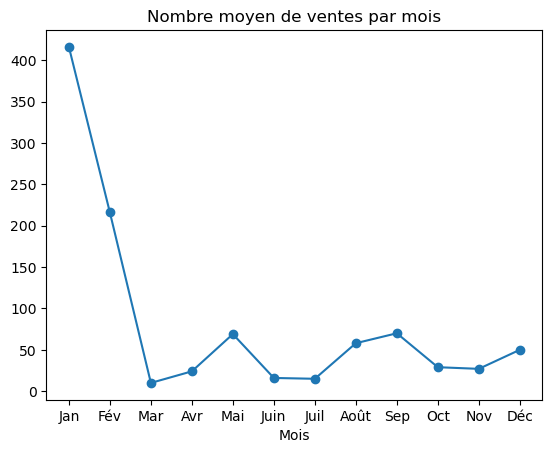

In [96]:
plt.plot(ventes_par_mois.index,ventes_par_mois.values, marker='o',linestyle='-')
plt.title('Nombre moyen de ventes par mois')
plt.xlabel('Mois')
plt.xticks(range(1, 13), ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Déc'])